In [1]:
!git clone https://github.com/garima-mahato/ERA_V1.git

Cloning into 'ERA_V1'...
remote: Enumerating objects: 207, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 207 (delta 98), reused 121 (delta 39), pack-reused 0
Receiving objects: 100% (207/207), 4.76 MiB | 19.83 MiB/s, done.
Resolving deltas: 100% (98/98), done.


In [2]:
from ERA_V1.Session8_BatchNormalizationAndRegularization import *

In [3]:

# # CUDA?

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = set_device()

CUDA Available? True


## Model Architecture

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# C1 C2 c3 P1 C3 C4 C5 c6 P2 C7 C8 C9 GAP C10

class CIFAR10_Classifier_GN(nn.Module):

    def __init__(self, num_groups=4, dropout_value=0):
        super(CIFAR10_Classifier_GN, self).__init__()
        self.num_groups = num_groups
        # Input Block C1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(self.num_groups, 16),
            nn.Dropout(dropout_value)
        ) # input_size = 32x32x3, output_size = 30x30x64, RF = 3x3

        # CONVOLUTION BLOCK 1 C2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(self.num_groups, 32),
            nn.Dropout(dropout_value)
        ) # input_size = 30x30x64, output_size = 30x30x128, RF = 5x5

        # TRANSITION BLOCK 1 c3
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 30x30x128, output_size = 30x30x128, RF = 5x5
        self.shortcut1 = nn.Sequential()

        # P1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 30x30x128, output_size = 16x16, RF = 6x6

        # CONVOLUTION BLOCK 2 C3
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(self.num_groups, 24),
            nn.Dropout(dropout_value)
        ) # input_size = 12x12x10, output_size = 13x13, RF = 10x10

        # C4
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=28, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(self.num_groups, 28),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14

        # C5
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(self.num_groups, 32),
            nn.Dropout(dropout_value)
        ) # input_size = 8x8x16, output_size = 6x6x20, RF = 18x18

        # TRANSITION BLOCK 1 c6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x14, output_size = 24x24x10, RF = 5x5
        self.shortcut2 = nn.Sequential()

        # P2
        self.pool2 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 8x8, RF = 6x6

         # CONVOLUTION BLOCK 2 C7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(self.num_groups, 20),
            nn.Dropout(dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10

        # C8
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=28, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(self.num_groups, 28),
            nn.Dropout(dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14

        # C9
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.GroupNorm(self.num_groups, 32),
            nn.Dropout(dropout_value)
        ) # input_size = 8x8x16, output_size = 6x6x20, RF = 18x18

        # OUTPUT BLOCK GAP
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # input_size = 6x6x20, output_size = 1x1x20, RF = 28x28

        # C10
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x20, output_size = 1x1x16, RF = 28x28

        # self.convblock8 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        # ) # input_size = 1x1x16, output_size = 1x1x10, RF = 28x28

        self.dropout = nn.Dropout(dropout_value)


    def forward(self, x):
        x = self.convblock1(x)
        y = self.convblock2(x)
        y = self.convblock3(y)
        y += self.shortcut1(x)
        y = F.relu(y)

        y = self.pool1(y)
        y1 = self.convblock4(y)
        y1 = self.convblock5(y1)
        y1 = self.convblock6(y1)
        y1 = self.convblock7(y1)
        y1 += self.shortcut2(y)
        y1 = F.relu(y1)

        y1 = self.pool2(y1)
        y1 = self.convblock8(y1)
        y1 = self.convblock9(y1)
        y1 = self.convblock10(y1)
        y1 = self.gap(y1)
        y1 = self.convblock11(y1)
        y1 = y1.view(-1, 10)

        return F.log_softmax(y1, dim=-1)

In [9]:
!pip install torchsummary
from torchsummary import summary

model = CIFAR10_Classifier_GN().to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
         GroupNorm-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
         GroupNorm-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
        MaxPool2d-10           [-1, 16, 16, 16]               0
           Conv2d-11           [-1, 24, 16, 16]           3,456
             ReLU-12           [-1, 24, 16, 16]               0
    

## Dataset Creation

In [10]:
# Train data transformations
train_transforms = transforms.Compose([
    #transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))
    ])

train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

# set seed
torch.manual_seed(1)

batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
kwargs.update({'batch_size': batch_size, 'shuffle': True})

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

100%|██████████| 170498071/170498071 [00:13<00:00, 12855670.57it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Data Visualization

In [11]:
CIFAR10_CLASS_LABELS = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

 ship  bird   cat   dog


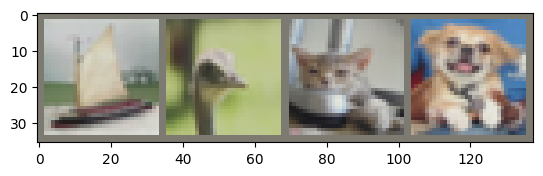

In [12]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % CIFAR10_CLASS_LABELS[labels[j]] for j in range(4)))

## Model Training and Testing

In [13]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

dropout_value = 0 #.05

model = CIFAR10_Classifier_GN(dropout_value=dropout_value).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, train_acc, train_losses)
  #scheduler.step()
  test(model, device, test_loader, test_acc, test_losses)


Epoch 1


Train: Loss=1.5306 Batch_id=390 Accuracy=36.48: 100%|██████████| 391/391 [00:20<00:00, 19.48it/s]


Test set: Average loss: 1.4840, Accuracy: 4458/10000 (44.58%)

Epoch 2


Train: Loss=1.2313 Batch_id=390 Accuracy=53.96: 100%|██████████| 391/391 [00:19<00:00, 20.47it/s]


Test set: Average loss: 1.1905, Accuracy: 5691/10000 (56.91%)

Epoch 3


Train: Loss=0.9978 Batch_id=390 Accuracy=61.65: 100%|██████████| 391/391 [00:18<00:00, 20.66it/s]


Test set: Average loss: 1.0877, Accuracy: 6094/10000 (60.94%)

Epoch 4


Train: Loss=0.8820 Batch_id=390 Accuracy=65.29: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]


Test set: Average loss: 0.9620, Accuracy: 6614/10000 (66.14%)

Epoch 5


Train: Loss=0.9931 Batch_id=390 Accuracy=68.30: 100%|██████████| 391/391 [00:19<00:00, 19.57it/s]


Test set: Average loss: 0.8844, Accuracy: 6875/10000 (68.75%)

Epoch 6


Train: Loss=1.0570 Batch_id=390 Accuracy=71.02: 100%|██████████| 391/391 [00:19<00:00, 19.60it/s]


Test set: Average loss: 0.8330, Accuracy: 7032/10000 (70.32%)

Epoch 7


Train: Loss=0.6323 Batch_id=390 Accuracy=73.09: 100%|██████████| 391/391 [00:20<00:00, 19.55it/s]


Test set: Average loss: 0.8228, Accuracy: 7120/10000 (71.20%)

Epoch 8


Train: Loss=0.5310 Batch_id=390 Accuracy=74.65: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]


Test set: Average loss: 0.7560, Accuracy: 7325/10000 (73.25%)

Epoch 9


Train: Loss=0.7021 Batch_id=390 Accuracy=76.32: 100%|██████████| 391/391 [00:19<00:00, 20.39it/s]


Test set: Average loss: 0.7814, Accuracy: 7312/10000 (73.12%)

Epoch 10


Train: Loss=0.6399 Batch_id=390 Accuracy=77.36: 100%|██████████| 391/391 [00:19<00:00, 19.74it/s]


Test set: Average loss: 0.7428, Accuracy: 7348/10000 (73.48%)

Epoch 11


Train: Loss=0.6346 Batch_id=390 Accuracy=78.00: 100%|██████████| 391/391 [00:20<00:00, 19.43it/s]


Test set: Average loss: 0.7384, Accuracy: 7455/10000 (74.55%)

Epoch 12


Train: Loss=0.4105 Batch_id=390 Accuracy=79.51: 100%|██████████| 391/391 [00:20<00:00, 19.22it/s]


Test set: Average loss: 0.7197, Accuracy: 7489/10000 (74.89%)

Epoch 13


Train: Loss=0.6398 Batch_id=390 Accuracy=79.90: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]


Test set: Average loss: 0.7232, Accuracy: 7522/10000 (75.22%)

Epoch 14


Train: Loss=0.5218 Batch_id=390 Accuracy=80.68: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]


Test set: Average loss: 0.6646, Accuracy: 7698/10000 (76.98%)

Epoch 15


Train: Loss=0.4599 Batch_id=390 Accuracy=81.22: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]


Test set: Average loss: 0.6925, Accuracy: 7587/10000 (75.87%)

Epoch 16


Train: Loss=0.5416 Batch_id=390 Accuracy=82.04: 100%|██████████| 391/391 [00:20<00:00, 19.32it/s]


Test set: Average loss: 0.6946, Accuracy: 7587/10000 (75.87%)

Epoch 17


Train: Loss=0.4043 Batch_id=390 Accuracy=82.41: 100%|██████████| 391/391 [00:20<00:00, 19.29it/s]


Test set: Average loss: 0.6540, Accuracy: 7728/10000 (77.28%)

Epoch 18


Train: Loss=0.5031 Batch_id=390 Accuracy=82.89: 100%|██████████| 391/391 [00:20<00:00, 19.13it/s]


Test set: Average loss: 0.7014, Accuracy: 7632/10000 (76.32%)

Epoch 19


Train: Loss=0.3903 Batch_id=390 Accuracy=83.37: 100%|██████████| 391/391 [00:19<00:00, 19.74it/s]


Test set: Average loss: 0.6668, Accuracy: 7735/10000 (77.35%)

Epoch 20


Train: Loss=0.4610 Batch_id=390 Accuracy=84.09: 100%|██████████| 391/391 [00:19<00:00, 19.68it/s]


Test set: Average loss: 0.6781, Accuracy: 7684/10000 (76.84%)



In [ ]:
# def save_network(path, model_file_name):
#     print("\n Saving trained model and parameters...")
#     torch.save(model.state_dict(), path+"/"+model_file_name+".pth")
#     # save train and test losses and accuracies
#     train_test_data = {"Training Loss": train_losses, "Test Loss": test_losses, "Training Accuracy": train_acc, "Test Accuracy": test_acc}
#     torch.save(train_test_data, path+"/"+model_file_name+"_train_test_params.pt")

# def load_network(path, model_file_name):
#     print("\n Loading trained model...")
#     model = model.to(device)
#     model.load_state_dict(torch.load(path+"/"+model_file_name+".pth"))

In [16]:
save_network('ERA_V1/Session8_BatchNormalizationAndRegularization', 'group_norm_saved_model', model, train_losses, test_losses, train_acc, test_acc)


 Saving trained model and parameters...


### Accuracy/Loss Visualization

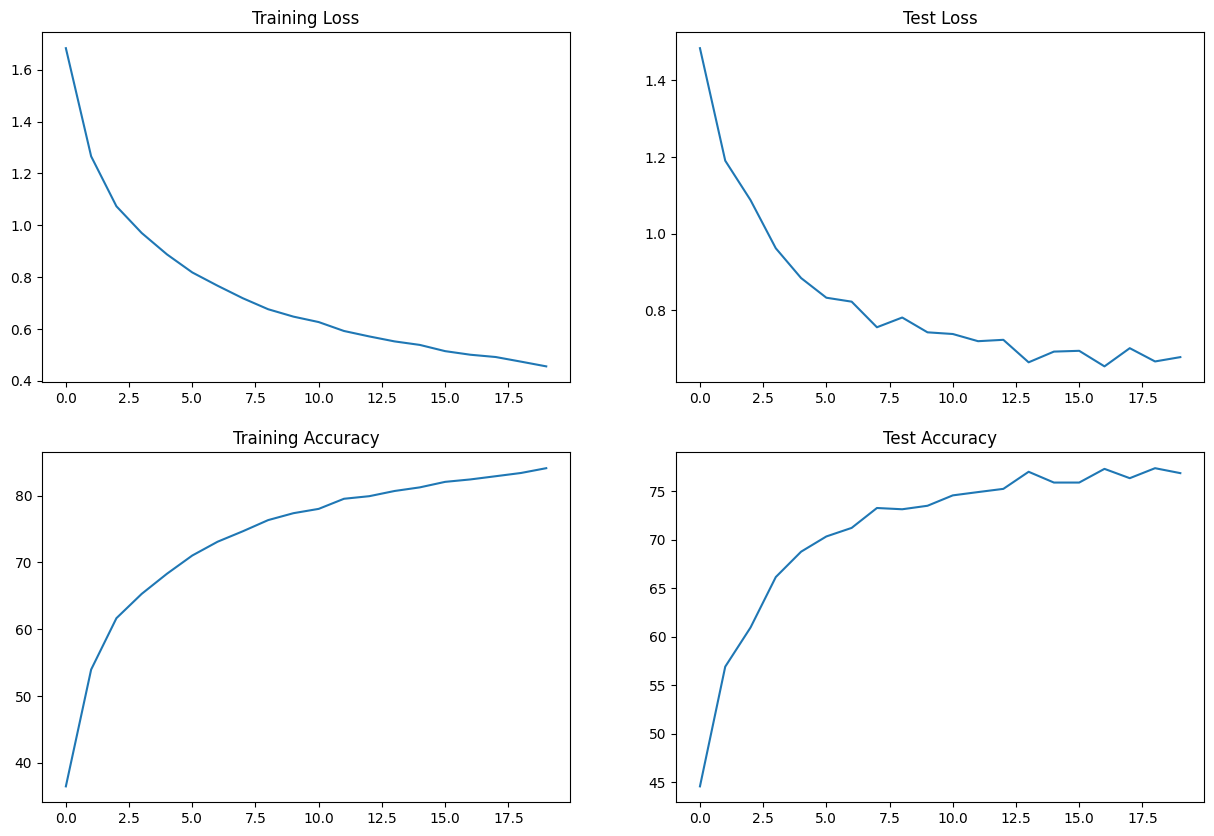

In [17]:
vis_train_test_comp_graphs(train_losses, train_acc, test_losses, test_acc)

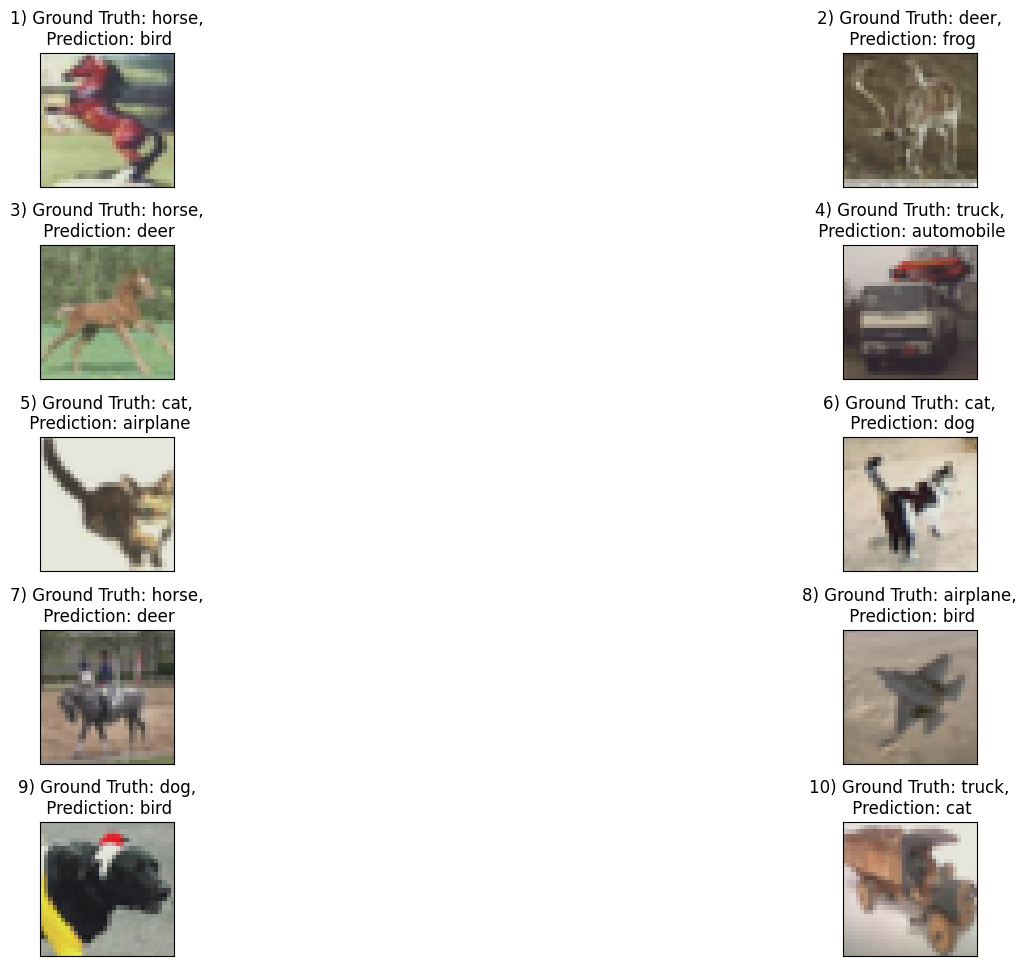

In [19]:
show_save_misclassified_images(model, test_loader, device, 'ERA_V1/Session8_BatchNormalizationAndRegularization/assets', name="cifar10_group_norm_misclassified_imgs", max_misclassified_imgs=10) #, is_cifar10=True, labels_list=CIFAR10_CLASS_LABELS)

In [20]:
%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-b7xk3i4w
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-b7xk3i4w
  Resolved https://github.com/szagoruyko/pytorchviz.git to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=33979e0569b9d55d1d89fa00bec047e72369be58491a1a1a4ab4a498a9391d3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-t6hgino9/wheels/97/11/17/d09e895f9883bd50923ce86b249a31790356a1b88b280983d8
Successfully built torchviz


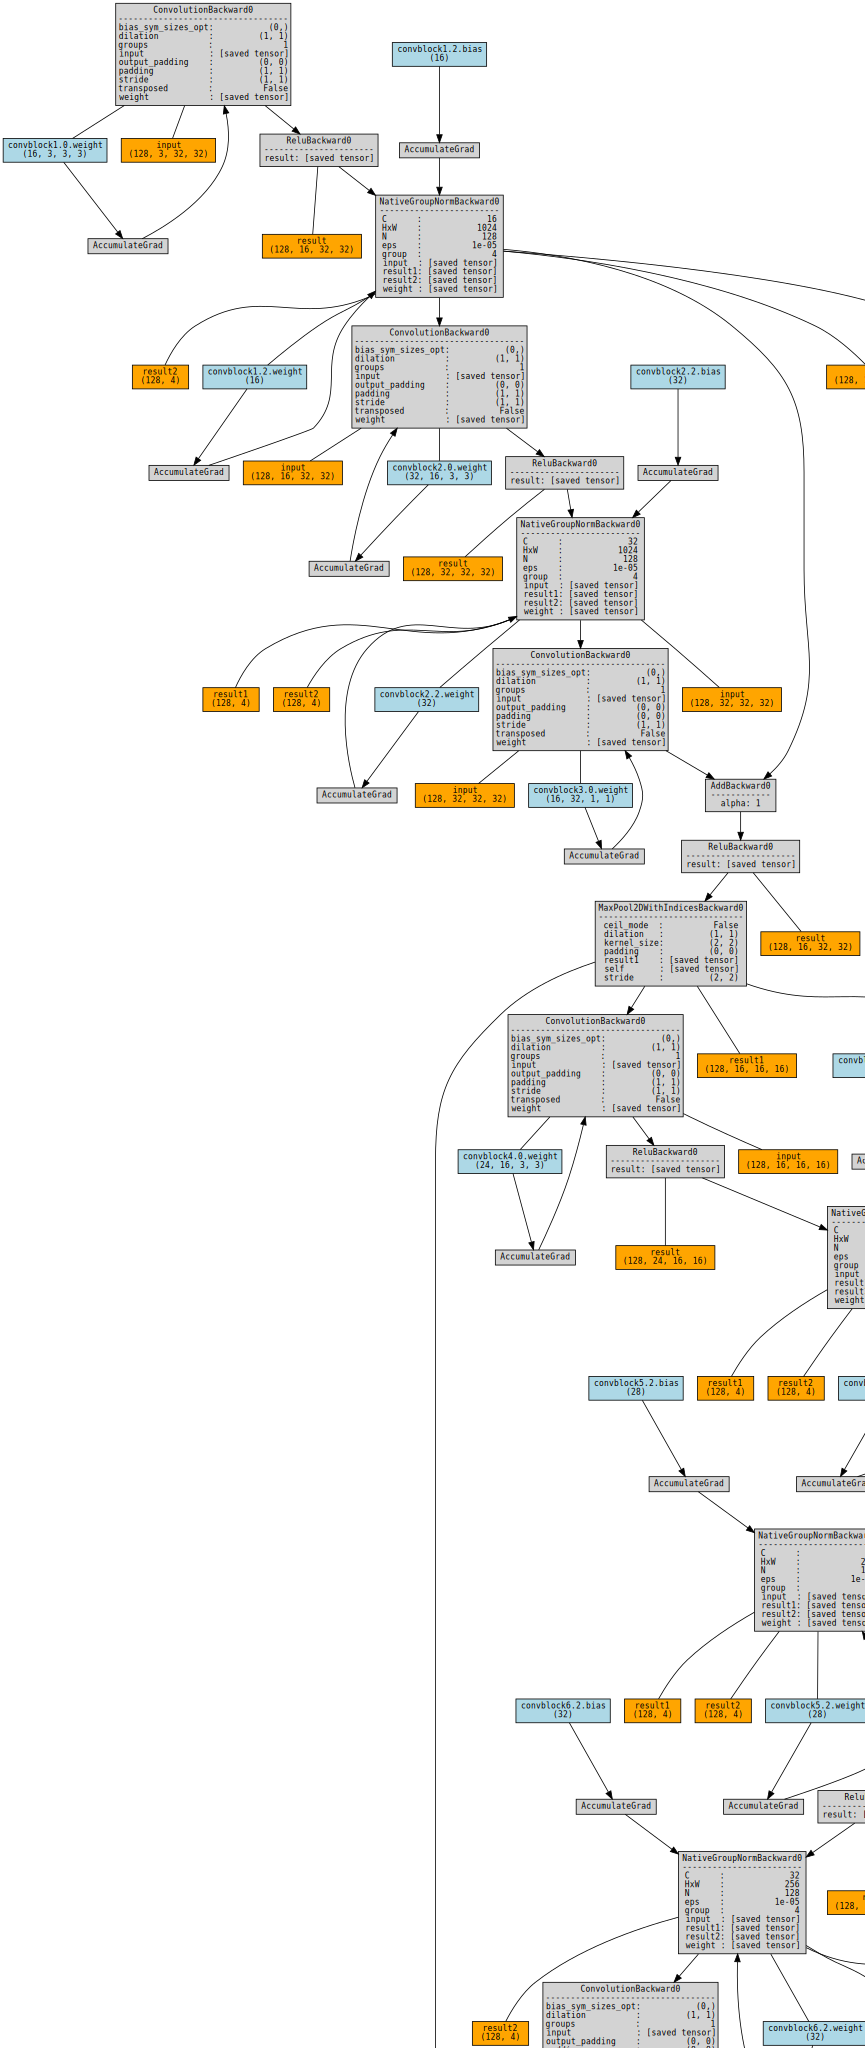

In [21]:
batch_data, batch_label = next(iter(train_loader))
batch_data = batch_data.to(device)
y = model(batch_data)

make_dot(y, params=dict(list(model.named_parameters())), show_attrs=True, show_saved=True)

In [23]:
make_dot(y, params=dict(list(model.named_parameters())), show_attrs=True, show_saved=True).render("cifar10_gn_torchviz", format="png")

'cifar10_gn_torchviz.png'